In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import cv2

from deepthink.layers import Conv3D, Dense, MaxPooling3D, GlobalAveragePooling3D
from deepthink.activations import Softmax, ReLU
from deepthink.model import Model
from deepthink.optimizers import Adam
from deepthink.loss import CategoricalCrossEntropy
from deepthink.utils import load_mnist_data

## MNIST 3D CNN Classifier

This notebook demonstrates how to train a 3D CNN on a subset of the MNIST dataset. We will train a classifier to distinguish between the digits 0 to 3. Reducing the size of the dataset and number of classes makes the task easier and faster to train.

To create the 3D data from the MNIST data we use the pixel values to create a depth dimension and set the active pixels to 1. This creates a 3D volume for each image. We use a 3D convolutional network to classify the images.

Training using 3D data is slower than 2D data since complexity grows with the number of dimensions. For this reason, we use a small network and train for only three epochs. This is sufficient to achieve reasonable accuracy on the test set. To get a better accuracy you can increase the number of epochs and/or use a larger network. However, in practice, it is generally preferable to use more efficient deep learning libraries such as TensorFlow or PyTorch to train a 3D CNN.

In [2]:
# Define hyperparameters
n_epochs = 3
learning_rate = 0.005
batch_size = 64
init_type = 'glorot_normal'
img_size = 16
input_shape = (batch_size, 1, img_size, img_size, img_size)

# Set default matplotlib style
plt.style.use('dark_background')

In [3]:
# Load the MNIST dataset
training_data, test_data = load_mnist_data('../Data/mnist784.p')

x_train, y_train = training_data
x_test, y_test = test_data

# Show dataset dimensions
print('Training data & labels: ', x_train.shape, y_train.shape)
print('Testing data & labels: ', x_test.shape, y_test.shape)

Training data & labels:  (60000, 1, 28, 28) (60000, 10)
Testing data & labels:  (10000, 1, 28, 28) (10000, 10)


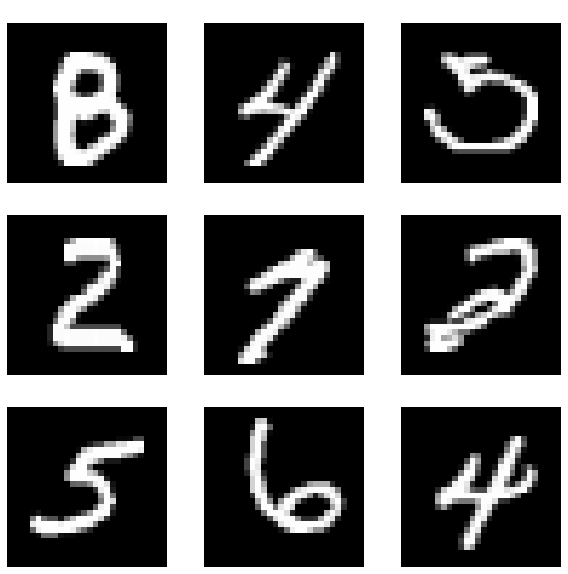

In [4]:
# Visualize some of the training data
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    axes[i // 3, i % 3].imshow(x_train[i][0], cmap='gray')
    axes[i // 3, i % 3].set_title('Label: {}'.format(y_train[i].argmax()))
    axes[i // 3, i % 3].axis('off')
plt.show()

In [5]:
# Keep only samples with labels 0 to max_label 
max_label = 3
x_train = x_train[y_train.argmax(axis=1) <= max_label]
y_train = y_train[y_train.argmax(axis=1) <= max_label][:, :max_label + 1]
x_test = x_test[y_test.argmax(axis=1) <= max_label]
y_test = y_test[y_test.argmax(axis=1) <= max_label][:, :max_label + 1]

# Show new dataset dimensions
print('Training data & labels: ', x_train.shape, y_train.shape)
print('Testing data & labels: ', x_test.shape, y_test.shape)

Training data & labels:  (24754, 1, 28, 28) (24754, 4)
Testing data & labels:  (4157, 1, 28, 28) (4157, 4)


In [6]:
# Resize images to 16x16
x_train = np.array([cv2.resize(x[0], (img_size, img_size)) for x in x_train])
x_test = np.array([cv2.resize(x[0], (img_size, img_size)) for x in x_test])

# Add a channel dimension to the images
x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)

# Show resized dataset dimensions
print('Training data & labels: ', x_train.shape, y_train.shape)
print('Testing data & labels: ', x_test.shape, y_test.shape)

Training data & labels:  (24754, 1, 16, 16) (24754, 4)
Testing data & labels:  (4157, 1, 16, 16) (4157, 4)


In [7]:
def convert_2d_to_3d(data_2d):
    """
    Converts 2D image dataset to 3D by adding a depth dimension.

    Parameters
    ----------
    data_2d : numpy.ndarray
        The 2D image to convert to 3D. The shape of the array
        should be (n_samples, n_channels, height, width).
    
    Returns
    -------
    numpy.ndarray
        The 3D image with depth dimension added.
    """
    # Get the dimensions of the input array
    n_samples = data_2d.shape[0]
    n_channels = data_2d.shape[1]
    image_size = data_2d.shape[2]

    # Create a new array with the same shape as the desired output
    data_3d = np.zeros((n_samples, n_channels, image_size,
                        image_size, image_size))

    # Iterate over each image in the input array
    for i in range(n_samples):
        # Get the 2D pixel values for the current image
        pixels_2d = data_2d[i, 0]

        # Calculate the depth dimension based on the pixel values
        pixels_3d = np.zeros((image_size, image_size, image_size))
        for x in range(image_size):
            for y in range(image_size):
                # Calculate the depth based on the pixel value
                depth = int(pixels_2d[x, y] * image_size)
                # Set the depth dimension to 1 for the corresponding pixels
                pixels_3d[x, y, :depth] = 1

        # Add the resulting 3D image to the output array
        data_3d[i, 0] = pixels_3d

    return data_3d


In [8]:
x_train_3d = convert_2d_to_3d(x_train)
x_test_3d = convert_2d_to_3d(x_test)

# Show 3D dataset dimensions
print('Training data & labels: ', x_train_3d.shape, y_train.shape)
print('Testing data & labels: ', x_test_3d.shape, y_test.shape)

Training data & labels:  (24754, 1, 16, 16, 16) (24754, 4)
Testing data & labels:  (4157, 1, 16, 16, 16) (4157, 4)


In [9]:
def plot_3d_image(image, label):
    """Plots a 3D image with the corresponding label.
    
    Uses Plotly to plot a 3D image with the corresponding label.
    The image is plotted as a 3D surface plot, where the height
    of the surface is determined by the pixel values. The label
    is displayed as the title of the plot.
    
    The shape of the image array should be (height, width, depth).
    """
    x, y, z = np.indices((16, 16, 16))
    data = go.Volume(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=image.flatten(),
        isomin=image.min(),
        isomax=image.max(),
        opacity=0.1,
        surface_count=17,
        colorscale='plotly3',
    )
    fig = go.Figure(data=data)
    fig.update_layout(
        title=f'Label: {label}',
        paper_bgcolor ='rgb(10,10,10)'
    )
    fig.show()

In [10]:
# Visualize a random sample from dataset
sample_idx = np.random.randint(0, x_train_3d.shape[0])

sample_img = x_train_3d[sample_idx, 0]
sample_label = y_train[sample_idx].argmax()

plot_3d_image(sample_img, sample_label)

In [11]:
# Creating the model
opt = Adam(learning_rate)
model = Model(opt, cost=CategoricalCrossEntropy(),
              metrics=['accuracy'],
              batch_size=batch_size)

model.add_layer(Conv3D(kernel_size=3, n_filters=4,
                       padding_type='valid', stride=1,
                       weight_init=init_type,
                       input_shape=input_shape))
model.add_layer(ReLU())
model.add_layer(Conv3D(kernel_size=3, n_filters=8,
                       padding_type='valid', stride=1,
                       weight_init=init_type))
model.add_layer(ReLU())
model.add_layer(MaxPooling3D())
model.add_layer(GlobalAveragePooling3D())
model.add_layer(Dense(8, weight_init=init_type))
model.add_layer(ReLU())
model.add_layer(Dense(max_label + 1, weight_init=init_type))
model.add_layer(Softmax())

model.initialize()

In [12]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Conv3D                    (None, 4, 14, 14, 14)                112
ReLU Activation           (None, 4, 14, 14, 14)                  0
Conv3D                    (None, 8, 12, 12, 12)                872
ReLU Activation           (None, 8, 12, 12, 12)                  0
MaxPooling3D              (None, 8, 6, 6, 6)                    0
GlobalAveragePooling3D    (None, 8)                             0
Dense(8)                  (None, 8)                            72
ReLU Activation           (None, 8)                             0
Dense(4)                  (None, 4)                            36
Softmax Activation        (None, 4)                             0
Total params: 1092


In [13]:
# Training the model
history = model.train((x_train_3d, y_train),
                        validation_data=(x_test_3d, y_test),
                        epochs=n_epochs)

100%|██████████| 386/386 [03:48<00:00,  1.69it/s]


Epoch: 1/3, elapsed-time: 291.18s - loss: 0.2700 - accuracy: 0.9056 - val_loss: 0.2296 - val_accuracy: 0.9248 - 


100%|██████████| 386/386 [03:48<00:00,  1.69it/s]


Epoch: 2/3, elapsed-time: 529.26s - loss: 0.2099 - accuracy: 0.9282 - val_loss: 0.1435 - val_accuracy: 0.9568 - 


100%|██████████| 386/386 [03:49<00:00,  1.68it/s]


Epoch: 3/3, elapsed-time: 768.53s - loss: 0.1739 - accuracy: 0.9413 - val_loss: 0.1217 - val_accuracy: 0.9651 - 


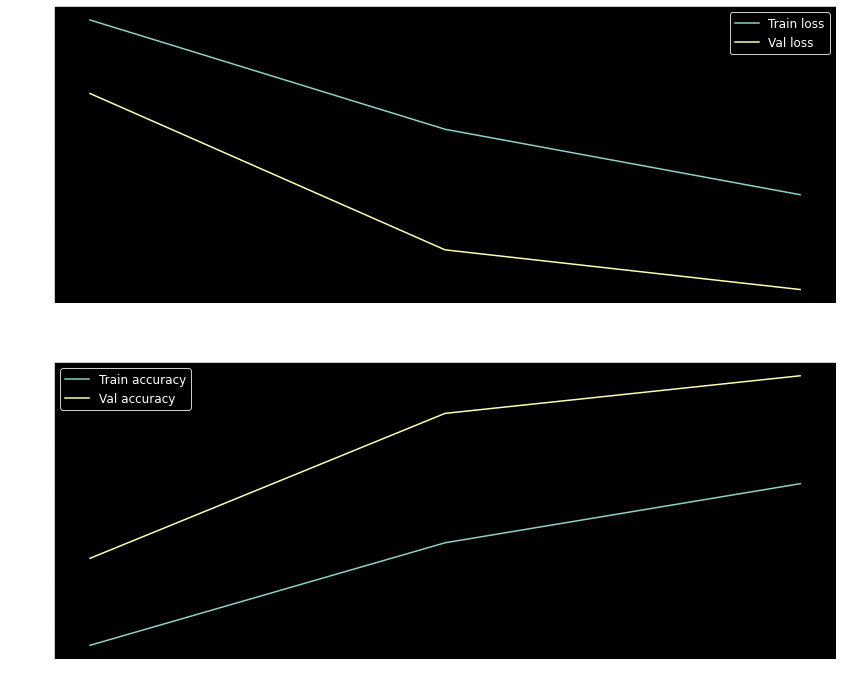

In [14]:
history.plot_history()